In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mpl_toolkits
from mpl_toolkits import mplot3d
import rosbag
import glob
#import os
#import rospy
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics

In [2]:
data_path = './Robot_ViconAugust/'
#'/vicon/atag/atag---Aug tag name
#'/vicon/PEE/PEE' -- Nov tag name
#/vicon/packbot_endEff/packbot_endEff -- Oct tag name

In [3]:
# Extract Vicon and camera stationary data
## Load Vicon data
vicobags_stat = glob.glob(data_path+'VS/*.bag')   
for i,bag in enumerate(vicobags_stat): # loop over vicon bags
    vsbag = rosbag.Bag(bag)
    vicon_statXpos = []
    vicon_statYpos = []
    vicon_statZpos = []
    for topicc, msgg, tt in vsbag.read_messages(topics=['/vicon/atag/atag']): # extract data
        vicon_statXpos.append(msgg.transform.translation.x)
        vicon_statYpos.append(msgg.transform.translation.y)
        vicon_statZpos.append(msgg.transform.translation.z)  
    vsbag.close()

    vicon_statXPosArr = np.array(vicon_statXpos)
    vicon_statYPosArr = np.array(vicon_statYpos)
    vicon_statZPosArr = np.array(vicon_statZpos)
    vicon_statPosArr = np.column_stack((vicon_statXPosArr,vicon_statYPosArr,vicon_statZPosArr)) 
    np.save(data_path+'vicon_statPosArr_%d.npy'%i, vicon_statPosArr) # save to numpy
    
# Load Robot data    
robobags_stat = glob.glob(data_path+'RS/*.bag')
for i,bag in enumerate(robobags_stat): # loop over robot bags
    rsbag = rosbag.Bag(bag)
    robot_statXpos = []
    robot_statYpos = []
    robot_statZpos = []
    robotbag_Tagtime = []
    for topi, msgs, tym in rsbag.read_messages(topics=['/tag_detections']): # extract data
        try:
            robot_statXpos.append(msgs.detections[0].pose.pose.pose.position.x)
            robot_statYpos.append(msgs.detections[0].pose.pose.pose.position.y)
            robot_statZpos.append(msgs.detections[0].pose.pose.pose.position.z)   
            robotbag_Tagtime.append(t.secs)
        except:
            continue

    robot_statXposArr = np.array(robot_statXpos)
    robot_statYposArr = np.array(robot_statYpos)
    robot_statZposArr = np.array(robot_statZpos)
    robot_statposArr = np.column_stack((robot_statXposArr,robot_statYposArr,robot_statZposArr))
    #np.save(data_path+'robot_statPosArr_%d.npy'%i, robot_statposArr)
    
    
    robotbag_Jointstime = []
    ja_list = []
    for topic2, msg2, t2 in rsbag.read_messages(topics=['/Packbot510/joints']):
        ja_list.append(msg2.position[:3])
        robotbag_Jointstime.append(t2.secs)
    ja_array_stat = np.array(ja_list)
    rsbag.close()
    np.save(data_path+'ja_array_stat%d.npy'%i, ja_array_stat)

In [4]:
print(len(vicon_statPosArr))
print(len(robot_statposArr))
print(len(ja_array_stat))

8830
884
850


In [5]:
# Sanity check loading data we just saved
vicon_list = []
Kinematics_list = []
for i in range(len(vicobags_stat)):
    vicon = np.load(data_path+'vicon_statPosArr_%d.npy'%i)
    vicon_list.append(vicon)
    
    #vl_arr = (np.array(vicon_list)).reshape(len(vicobags_stat),3)
    RobotKin = np.load(data_path+'ja_array_stat%d.npy'%i)
    Kinematics_list.append(RobotKin)

In [6]:

robot = URDF.from_xml_file('robot.urdf')
links = [rl.name for rl in robot.links]
kdl_kin = KDLKinematics(robot,'base_link','elbow2_link')
print(kdl_kin.get_joint_names())

BaseTo_ee_xyz = []
for d in Kinematics_list:
    ee_list = []
    for joint in d:
        posez = kdl_kin.forward(joint)
        ee_list.append(posez[0:3,3])
    BaseTo_ee_xyz.append(np.squeeze(np.array(ee_list)))
#print(BaseTo_ee_XYZarray.shape)
np.save(data_path+'BaseTo_ee_xyz.npy', BaseTo_ee_xyz)

['turret', 'shoulder', 'elbow1']


In [7]:
# Create procrustes function to use later
def procrustes(matx1,matx2):

    # translate all the data to the origin
    mean1 =  np.mean(matx1, 0)
    mean2 =  np.mean(matx2, 0)
    matx1 -= mean1
    matx2 -= mean2

    norm1 = np.linalg.norm(matx1)
    norm2 = np.linalg.norm(matx2)

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    matx1 /= norm1
    matx2 /= norm2

    L,D,M = np.linalg.svd(matx1.T.dot(matx2))
    
    s = np.sum(D)*norm1/norm2

    Rot = L.dot(M)
    tra = mean1 - (s*np.dot(Rot,mean2.T)).T

    return Rot, tra.reshape(-1,1), s

In [8]:
(BaseTo_ee_xyz[0]).shape

(1573, 3)

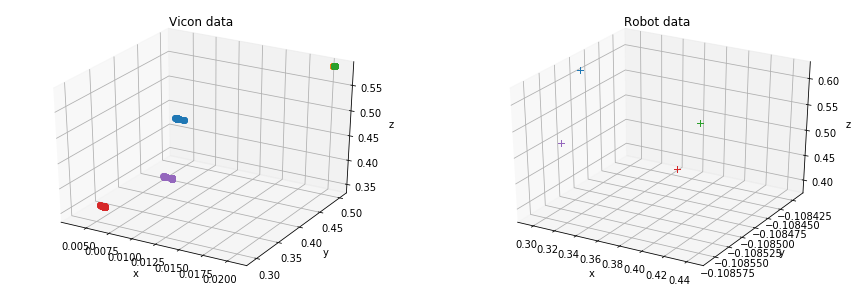

In [9]:
# Plot data we just loaded
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
for i in range(len(vicon_list)):
    
    ax0.plot(vicon_list[i][:,0],vicon_list[i][:,1],vicon_list[i][:,2],'o')
    ax1.plot(BaseTo_ee_xyz[i][:,0],BaseTo_ee_xyz[i][:,1],BaseTo_ee_xyz[i][:,2],'+')
    
# ax0.set_xlim(0,0.5)
# ax0.set_ylim(0,0.5)
# ax0.set_zlim(0,0.5)
ax0.set_ylabel('y')
ax0.set_xlabel('x')
ax0.set_zlabel('z')
ax0.set_title('Vicon data')

# ax1.set_xlim(0,0.5)
# ax1.set_ylim(0,0.5)
# ax1.set_zlim(0,0.5)
ax1.set_title('Robot data')
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_zlabel('z')

plt.show()
#visualstudiocode

In [10]:
# Get means 
vicon_means = [np.mean(d,axis=0) for d in vicon_list]
robot_means = [np.mean(d,axis=0) for d in BaseTo_ee_xyz]

Rot, trans,scale = procrustes(np.array(vicon_means),np.array(robot_means))
print(Rot)
print(trans)
print(scale) # should be close to 1 for good data

# Save calibration parameters for use in dynamics analysis

np.save(data_path+'Rot.npy',Rot)
np.save(data_path+'trans.npy',trans)
np.save(data_path+'scale.npy',scale)

# Rotate Robot data into Vicon frame of reference
robot_v_list = [scale*np.dot(Rot,d.T).T + trans.T for d in BaseTo_ee_xyz]

[[ 0.0140357  -0.99875095  0.04795341]
 [ 0.99284131  0.0196096   0.11782021]
 [-0.11861339  0.04595644  0.99187644]]
[[-0.14334862]
 [-0.09009064]
 [-0.05178954]]
1.12745342573


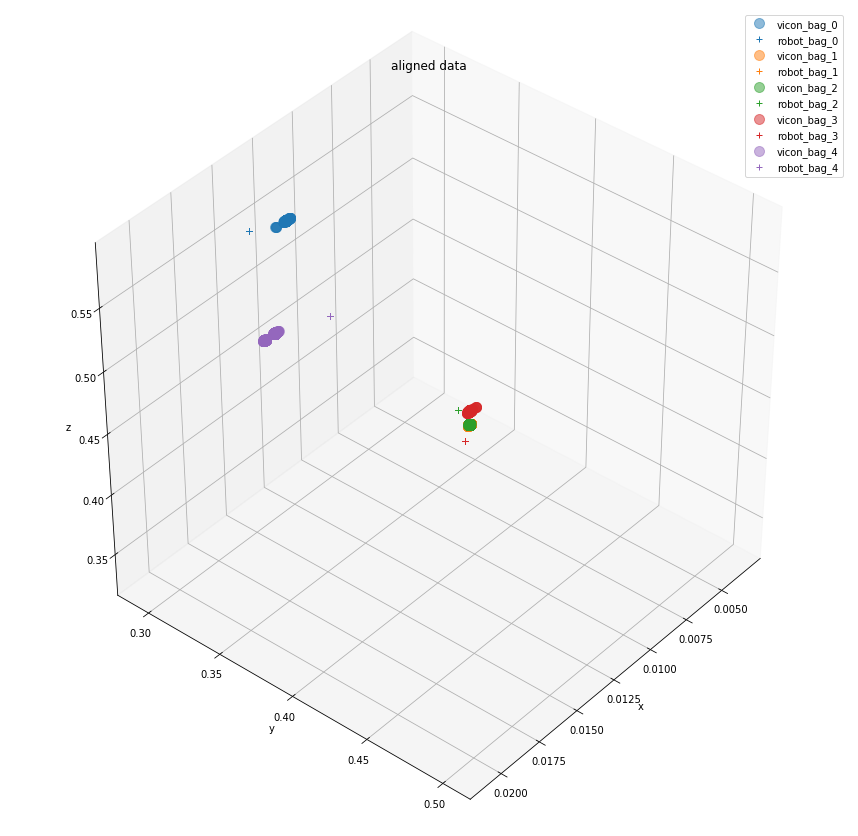

In [11]:
# Plot rotates data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(vicon_list)):
    
    ax.plot(vicon_list[i][:,0],vicon_list[i][:,1],vicon_list[i][:,2],
            'o',color='C%d'%i,alpha=0.5,markersize=10,label='vicon_bag_%d'%i)
    ax.plot(robot_v_list[i][:,0],robot_v_list[i][:,1],robot_v_list[i][:,2],
            '+',color='C%d'%i,label='robot_bag_%d'%i)
    
# ax.set_xlim(-0.2,0.5) # set limits, making sure axis scale is the same - 0.4 between all
# ax.set_ylim(0.2,0.6)
# ax.set_zlim(0.2,0.6)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')

ax.set_title('aligned data')

ax.legend()

ax.view_init(elev=40., azim=40) # Change viewing angle to see better

plt.show()

In [ ]:
#plot fk data and vicon data for alignement
#Nov data colors are gvng problems
#Not lining up too well - procrustes seems to have failed
#do vs for interactive plotting